In [1]:
!pip install --no-deps simplejson
!pip install --no-deps citylearn==1.8.0
# !pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 19.1 MB/s eta 0:00:00


In [2]:
# system files
import sys, os

# type hinting
from typing import List, Mapping

# Data visualization
import time
import matplotlib.pyplot as plt

# Data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet

# custom modules
cwd = '/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC'
sys.path.append(os.path.join(cwd))
from preprocessing import set_schema_buildings, set_schema_simulation_period, set_active_observations, get_timestep
from plot_kpi import plot_simulation_summary, plot_actions, plot_rewards
from mpc import MPC

%matplotlib inline

# Suppress DeprecationWarnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
DATASET_NAME = 'citylearn_challenge_2022_phase_all'
schema = DataSet.get_schema(DATASET_NAME)

root_directory = schema['root_directory']

In [4]:
# edit next code line to change number of buildings in simulation
BUILDING_INDEX = [7]

# edit next code line to change active observations in simulation
ACTIVE_OBSERVATIONS = ['month',
                       'day_type',
                       'hour',
                       'diffuse_solar_irradiance',
                       'diffuse_solar_irradiance_predicted_6h',
                       'diffuse_solar_irradiance_predicted_12h',
                       'direct_solar_irradiance',
                       'direct_solar_irradiance_predicted_6h',
                       'direct_solar_irradiance_predicted_12h',
                       'carbon_intensity',
                       'non_shiftable_load',
                       'solar_generation',
                       'electrical_storage_soc',
                       ]

schema, buildings = set_schema_buildings(schema, BUILDING_INDEX)
schema = set_active_observations(schema, ACTIVE_OBSERVATIONS)

print('Selected buildings:', buildings)
print(f'Active observations:', ACTIVE_OBSERVATIONS)

Selected buildings: ['Building_7']
Active observations: ['month', 'day_type', 'hour', 'diffuse_solar_irradiance', 'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'carbon_intensity', 'non_shiftable_load', 'solar_generation', 'electrical_storage_soc']


In [5]:
# set pricing obervation to shared
# デフォルトだと、電力料金は住宅ごとで分かれているため、ひとつにまとめる
pricing_obs = ['electricity_pricing',
               'electricity_pricing_predicted_6h',
               'electricity_pricing_predicted_12h',
               'electricity_pricing_predicted_24h']

for ob in pricing_obs:
    schema["observations"][ob]['shared_in_central_agent']=True

In [6]:
# １つのAgentですべての住宅を制御
schema['central_agent'] = True

In [109]:
analysis_schema = schema.copy()

# Testing timestep
START = get_timestep(6,17,0)
STOP = get_timestep(6,23,23)

analysis_schema = set_schema_simulation_period(analysis_schema,
                                               START, STOP)

print(f'Selected time steps:', (START, STOP))

Selected time steps: (7848, 8015)


# Analysis

In [26]:
mpc_env = CityLearnEnv(analysis_schema)

In [27]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Building-level KPIs:


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


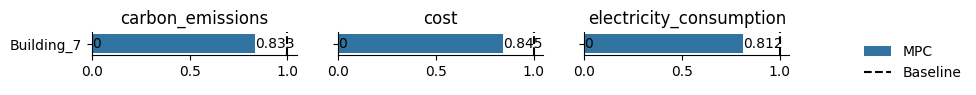

Building-level load profiles:


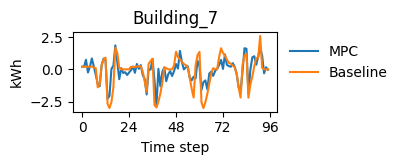

Battery SoC profiles:


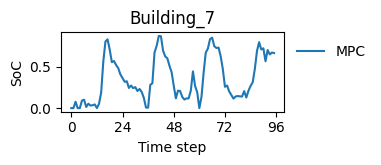

District-level KPIs:


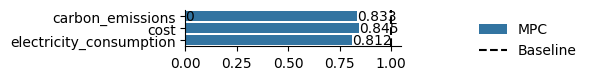

District-level load profiles:


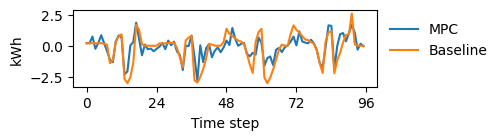

In [ ]:
observations = mpc_env.reset()
actions_list = []
observations_list = []
hist_list = []
states_list = []

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    hist = mpc_de.optimize(generations=2500)
    hist_list.append(hist)
    actions = mpc_de.predict_mpc()
    actions_list.append(actions)
    observations, _, _, _ = mpc_env.step([actions])
    mpc_de.update_mpc()

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/actions1.txt"), np.array(actions_list), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/observations1.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/states1.txt"), np.array(states_list), delimiter=",")

ValueError: Expected 1D or 2D array, got 3D array instead

In [ ]:
np.savetxt(os.path.join(cwd, "month_analysis/history1.txt"), np.array(hist_list), delimiter=",")

In [ ]:
[plt.plot(hist_list[i]) for i in range(len(hist_list))];

# rerun

In [110]:
actions = np.loadtxt(os.path.join(cwd,"month_analysis","actions4.txt"),delimiter=",")

In [111]:
mpc_env = CityLearnEnv(analysis_schema)

In [112]:
mpc_de = MPC(analysis_schema,mpc_env,
          model_folder = os.path.join(cwd,"models"))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultiOutputRegressor from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


/content/drive/MyDrive/Colab Notebooks/CityLearn_MPC/plot_kpi.py:117: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Building-level KPIs:


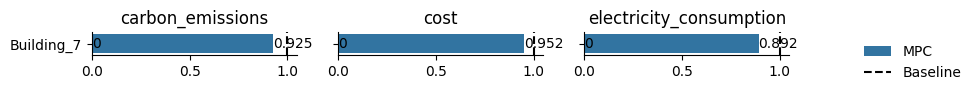

Building-level load profiles:


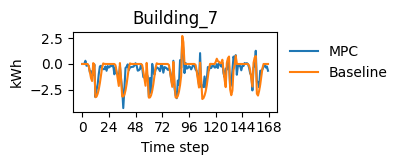

Battery SoC profiles:


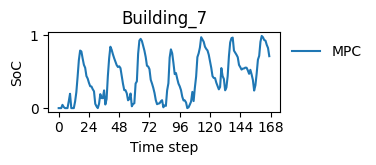

District-level KPIs:


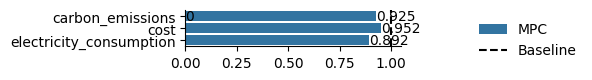

District-level load profiles:


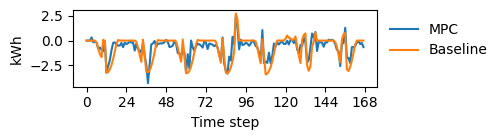

In [113]:
observations = mpc_env.reset()
observations_list = []
states_list = []
i = 0

while not mpc_env.done:
    observations_list.append(observations)
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    states_list.append(np.array(inputs))
    # _ = mpc_de.optimize(generations=2500)
    # actions = mpc_de.predict_mpc()
    observations, _, _, _ = mpc_env.step([[actions[i]]])
    mpc_de.update_mpc()
    i += 1

plot_simulation_summary(
    {'MPC': mpc_env}
)

In [115]:
np.savetxt(os.path.join(cwd, "month_analysis/observations4.txt"), np.array(observations_list).reshape(-1,13), delimiter=",")

In [114]:
np.savetxt(os.path.join(cwd, "month_analysis/states4.txt"), np.array(states_list).reshape(-1,24*4), delimiter=",")

# Surrogate model inputs

In [ ]:
mpc_env.reset()
input_list = []

while not mpc_env.done:
    inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
    inputs.append(mpc_de.future_electricity_pricing)
    inputs.append(mpc_de.future_carbon_intensity)
    input_list.append(np.array(inputs))
    _, _, _, _ = mpc_env.step([[0]])
    mpc_de.update_mpc()

inputs = [d[k] for d in mpc_de.future_states.values() for k in d]
inputs.append(mpc_de.future_electricity_pricing)
inputs.append(mpc_de.future_carbon_intensity)
input_list.append(np.array(inputs))
input_list = np.array(input_list)

In [ ]:
np.savetxt(os.path.join(cwd,"month_analysis","surrogate_input.csv"),input_list.reshape(-1,4*24),delimiter=",")

In [ ]:
input_list

array([[[ 4.71788292e-01,  3.62920399e-01,  2.45820792e-01, ...,
          7.60545091e-01,  5.71394947e-01,  5.99775299e-01],
        [ 1.78330159e-03,  2.70422627e-04,  2.81774364e-03, ...,
          8.92673868e-03,  2.84644446e-03,  5.06021852e-05],
        [ 2.20000000e-01,  2.20000000e-01,  2.20000000e-01, ...,
          2.20000000e-01,  2.20000000e-01,  2.20000000e-01],
        [ 8.73453526e-02,  8.10781887e-02,  7.97044048e-02, ...,
          1.29024382e-01,  1.13914370e-01,  1.00652054e-01]],

       [[ 2.63999138e-01,  2.88116678e-01,  3.18982814e-01, ...,
          8.45553736e-01,  5.03051507e-01,  4.60300657e-01],
        [ 2.44545512e-03,  9.38984819e-04,  3.53519014e-03, ...,
          2.34371982e-03,  3.60601785e-03,  2.47634531e-03],
        [ 2.20000000e-01,  2.20000000e-01,  2.20000000e-01, ...,
          2.20000000e-01,  2.20000000e-01,  2.20000000e-01],
        [ 8.07951403e-02,  8.03713700e-02,  8.31732484e-02, ...,
          1.18909634e-01,  1.11470282e-01,  9.89099